In [1]:
import pandas as pd
import json
import os
#os.chdir(r'/content/drive/MyDrive/INRAE')

with open('129_annotated_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [2]:
def remove_text_duplicates(annotations):

    seen_texts = {}
    unique_annotations = []
    
    for item in annotations:

        if "data" in item and "text" in item["data"]:
            text = item["data"]["text"]
            
            if text not in seen_texts:
                seen_texts[text] = True
                unique_annotations.append(item)
                
    return unique_annotations

data = remove_text_duplicates(data)

print(f"Annotations uniques: {len(data)}")

Annotations uniques: 127


In [4]:
# from needed_functions import *

# analyze_labelstudio_annotations(data)

In [5]:
def filter_and_lowercase_entity_types(data, entity_types_to_remove):

    if isinstance(entity_types_to_remove, str):
        entity_types_to_remove = [entity_types_to_remove]
    
    # Créer une copie profonde des données pour éviter les modifications accidentelles
    import copy
    filtered_data = copy.deepcopy(data)
    
    # Parcourir chaque élément des données
    for item in filtered_data:
        # Si nous avons déjà un format filtré (structure tuple)
        if isinstance(item, tuple) and len(item) == 2 and isinstance(item[1], dict) and 'entities' in item[1]:
            text, annotations = item
            # Filtrer les entités
            filtered_entities = []
            for start, end, label in annotations['entities']:
                if label not in entity_types_to_remove:
                    # Convertir en minuscules
                    filtered_entities.append((start, end, label.lower()))
            # Mettre à jour les annotations
            annotations['entities'] = filtered_entities
        
        # Format Label Studio original
        elif 'annotations' in item and item['annotations']:
            for i, annotation_set in enumerate(item['annotations']):
                filtered_results = []
                
                for result in annotation_set.get('result', []):
                    if 'value' in result and 'labels' in result['value']:
                        # Vérifier si aucune des étiquettes n'est dans la liste à supprimer
                        labels = result['value']['labels']
                        if not any(label in entity_types_to_remove for label in labels):
                            # Convertir toutes les étiquettes en minuscules
                            result['value']['labels'] = [label.lower() for label in labels]
                            filtered_results.append(result)
                    else:
                        # Conserver les autres types d'annotations
                        filtered_results.append(result)
                
                # Mettre à jour les résultats filtrés
                item['annotations'][i]['result'] = filtered_results
    
    return filtered_data


filtered_data = filter_and_lowercase_entity_types(data, [
    "Nombre de magasins", 
    "Point de vente", 
    "Autres", 
    "Réseau de magasins",
    "Déclencheur",
    "Nombre de producteurs"
])

📊 Statistiques d'annotations :
Nombre total d'entités annotées : 2956
Répartition par label :
- information temporelle : 338
- magasin de producteurs : 302
- lieu : 766
- produit : 959
- producteur/artisan : 436
- organisation : 155


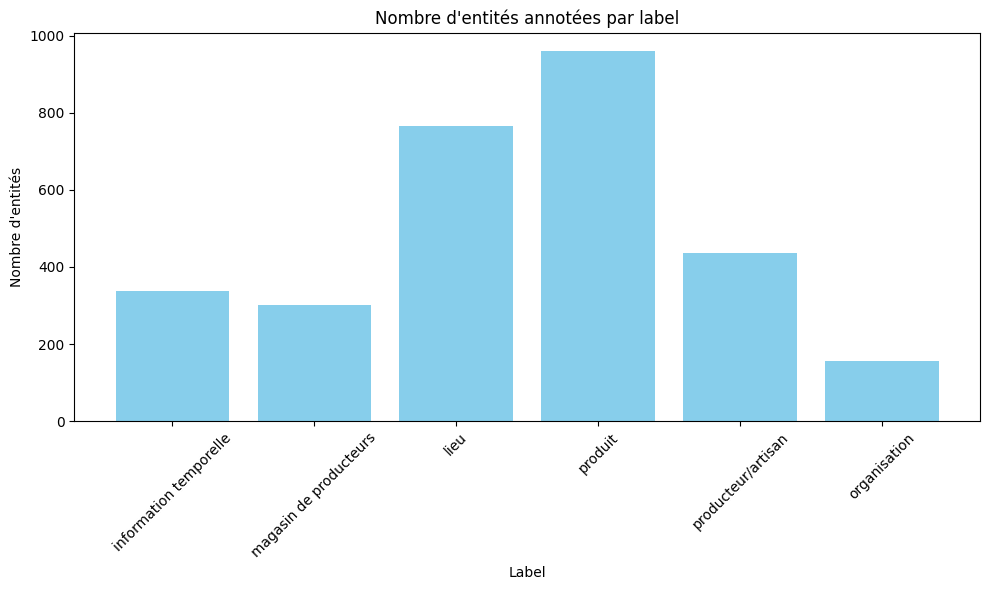

In [6]:
analyze_labelstudio_annotations(filtered_data)

In [7]:
import re

def label_studio_to_gliner(data):
    """
    Convertit un export Label Studio (format réel) en format :
    [{'tokenized_text': [...], 'ner': [[start_idx, end_idx, label], ...]}]

    Utilise une tokenisation qui sépare la ponctuation et conserve les apostrophes seules comme tokens distincts.
    """
    result = []

    for item in data:
        text = item['data'].get('text')
        if not text:
            continue

        annotations = item.get('annotations', [])
        if not annotations:
            continue

        # Tokenisation : mots + apostrophes + ponctuation séparée, y compris guillemets français
        tokens = re.findall(r"\w+|''|'|[.,!?;:\"«»()\-]", text)

        # Calculer les positions des tokens dans le texte
        token_spans = []
        offset = 0
        for token in tokens:
            match = re.search(re.escape(token), text[offset:])
            if match:
                start = offset + match.start()
                end = start + len(token)
                token_spans.append((start, end))
                offset = end

        ner = []
        for ann in annotations[0]['result']:
            value = ann['value']
            ent_start = value['start']
            ent_end = value['end']
            label = value['labels'][0]

            token_start = token_end = None
            for idx, (s, e) in enumerate(token_spans):
                if token_start is None and s <= ent_start < e:
                    token_start = idx
                if token_end is None and s < ent_end <= e:
                    token_end = idx
                if s >= ent_end:
                    break

            if token_start is not None and token_end is None:
                token_end = token_start

            if token_start is not None and token_end is not None:
                ner.append([token_start, token_end, label])

        result.append({'tokenized_text': tokens, 'ner': ner})

    return result


dataset = label_studio_to_gliner(data)

In [5]:
!pip install flair tqdm nltk -q
!pip install torch transformers huggingface_hub flair tqdm -q
!pip install evaluate utils -q
#!pip install -i https://testpypi.python.org/pypi gliner
#!pip install gliner

In [8]:
def segmenter_donnees_ner(data, max_tokens=512, stride=50):
    """
    Segmente les données NER en gardant uniquement les segments qui contiennent au moins une entité.

    Args:
        data: liste de dicts avec 'tokenized_text' et 'ner'
        max_tokens: taille maximale du segment
        stride: recouvrement entre les segments

    Returns:
        Liste de segments avec 'tokenized_text', 'ner' et 'original_start_idx'
    """
    donnees_segmentees = []

    for exemple in data:
        tokens = exemple['tokenized_text']
        spans = exemple['ner']

        if len(tokens) <= max_tokens:
            if spans:  # On garde seulement si une entité existe
                donnees_segmentees.append(exemple)
            continue

        for start_idx in range(0, len(tokens), max_tokens - stride):
            end_idx = min(start_idx + max_tokens, len(tokens))
            segment_tokens = tokens[start_idx:end_idx]

            segment_spans = []
            for span_start, span_end, span_type in spans:
                if span_end >= start_idx and span_start <= end_idx - 1:
                    adjusted_start = max(0, span_start - start_idx)
                    adjusted_end = min(span_end - start_idx, end_idx - start_idx - 1)

                    if adjusted_start <= adjusted_end:
                        segment_spans.append([adjusted_start, adjusted_end, span_type])

            if segment_spans:  # Garder uniquement les segments qui ont des entités
                segment_data = {
                    'tokenized_text': segment_tokens,
                    'ner': segment_spans,
                    'original_start_idx': start_idx
                }
                donnees_segmentees.append(segment_data)

            if end_idx == len(tokens):
                break

    return donnees_segmentees


In [9]:
train_dataset = dataset[:int(len(dataset)*0.8)]
val_dataset = dataset[int(len(dataset)*0.8):int(len(dataset)*0.9)]
test_dataset = data[int(len(data)*0.9):]

# Données d'entrainement
print("\nDonnées d'entrainement :")
print(f"Taille des données : {len(train_dataset)}")

print("\nDonnées de validation :")
print(f"Taille des données : {len(val_dataset)}")

# Données de test
print("\nDonnées de test :")
print(f"Taille des données : {len(test_dataset)}")



Données d'entrainement :
Taille des données : 101

Données de validation :
Taille des données : 13

Données de test :
Taille des données : 13


In [10]:
train_data = segmenter_donnees_ner(train_dataset, max_tokens=510, stride=51)
val_data = segmenter_donnees_ner(val_dataset, max_tokens=510, stride=51)
print(len(train_data))
print(len(val_data))

131
21


In [11]:
def check_max_token_count(data):

    if not data:
        return {"max_tokens": 0, "avg_tokens": 0, "token_counts": [], "texts_exceeding": {}}
    
    token_counts = []
    exceeding_counts = {256: 0, 384: 0, 512: 0, 768: 0, 1024: 0}
    
    for item in data:
        # Obtenir directement la liste de tokens
        tokens = item.get('tokenized_text', [])
        token_count = len(tokens)
        token_counts.append(token_count)
        
        # Compter les textes dépassant différents seuils
        for threshold in exceeding_counts.keys():
            if token_count > threshold:
                exceeding_counts[threshold] += 1
    
    max_tokens = max(token_counts) if token_counts else 0
    avg_tokens = sum(token_counts) / len(token_counts) if token_counts else 0
    
    # Calculer des percentiles pour voir la distribution
    sorted_counts = sorted(token_counts)
    percentiles = {
        "50th": sorted_counts[len(sorted_counts) // 2] if sorted_counts else 0,
        "75th": sorted_counts[int(len(sorted_counts) * 0.75)] if sorted_counts else 0,
        "90th": sorted_counts[int(len(sorted_counts) * 0.9)] if sorted_counts else 0,
        "95th": sorted_counts[int(len(sorted_counts) * 0.95)] if sorted_counts else 0
    }
    
    # Identifier les documents avec le plus de tokens
    top_documents = []
    if token_counts:
        # Trier les documents par nombre de tokens (décroissant)
        sorted_docs = sorted(enumerate(data), key=lambda x: len(x[1].get('tokenized_text', [])), reverse=True)
        # Prendre les 5 premiers documents
        for i, doc in sorted_docs[:5]:
            top_documents.append({
                "index": i,
                "token_count": len(doc.get('tokenized_text', [])),
                "first_tokens": ' '.join(doc.get('tokenized_text', [])[:10]) + "..." if len(doc.get('tokenized_text', [])) > 10 else ' '.join(doc.get('tokenized_text', [])),
                "entity_count": len(doc.get('ner', []))
            })
    
    return {
        "max_tokens": max_tokens,
        "avg_tokens": avg_tokens,
        "total_documents": len(data),
        "percentiles": percentiles,
        "token_counts": token_counts,
        "texts_exceeding": exceeding_counts,
        "top_documents": top_documents
    }

cg = check_max_token_count(train_data)
print(cg)

{'max_tokens': 510, 'avg_tokens': 332.1297709923664, 'total_documents': 131, 'percentiles': {'50th': 331, '75th': 510, '90th': 510, '95th': 510}, 'token_counts': [267, 494, 356, 67, 506, 510, 128, 246, 411, 493, 510, 54, 329, 389, 299, 510, 84, 316, 397, 499, 510, 146, 510, 96, 510, 162, 240, 510, 438, 510, 127, 488, 510, 193, 383, 323, 417, 297, 412, 472, 510, 120, 236, 336, 200, 297, 278, 510, 57, 510, 279, 238, 510, 150, 510, 147, 182, 376, 272, 510, 152, 510, 86, 121, 243, 224, 365, 510, 178, 220, 307, 268, 102, 510, 128, 276, 204, 236, 361, 238, 510, 510, 414, 215, 357, 331, 510, 336, 310, 167, 414, 210, 510, 70, 320, 499, 510, 510, 510, 155, 377, 187, 233, 485, 380, 202, 510, 367, 510, 261, 145, 94, 433, 221, 297, 259, 348, 465, 151, 510, 510, 510, 510, 509, 246, 234, 510, 107, 510, 59, 415], 'texts_exceeding': {256: 84, 384: 53, 512: 0, 768: 0, 1024: 0}, 'top_documents': [{'index': 5, 'token_count': 510, 'first_tokens': "Producteurs de fromages , de viande d ' autruche ou...", '

In [21]:
#!git clone https://github.com/urchade/GLiNER

In [13]:
#cd GLiNER

In [14]:
!ls

LICENSE		    build		demo.jpg  image.png	    tests
README.md	    configs		demo.py   logo		    train.py
README_Extended.md  convert_to_onnx.py	eval.py   models
RELEASE.md	    custom_train.py	examples  pyproject.toml
UNKNOWN.egg-info    data		gliner	  requirements.txt


In [15]:
#!pip install -r requirements.txt

In [16]:
#!pip install .

In [17]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

import torch
from gliner import GLiNERConfig, GLiNER
from gliner.training import Trainer, TrainingArguments
from gliner.data_processing.collator import DataCollatorWithPadding, DataCollator
from gliner.utils import load_config_as_namespace
from gliner.data_processing import WordsSplitter, GLiNERDataset

2025-05-19 07:48:39,561 - INFO - PyTorch version 2.6.0 available.


In [19]:
# model = GLiNER.from_pretrained("urchade/gliner_multi-v2.1", max_length=512)

# data_collator = DataCollator(model.config, data_processor=model.data_processor, prepare_labels=True)

# device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# model.to(device)
# print("done")

In [20]:
# Affiche les modules du backbone du modèle GLiNER
print(model.eval)

<bound method Module.eval of GLiNER(
  (model): SpanModel(
    (token_rep_layer): Encoder(
      (bert_layer): Transformer(
        (model): DebertaV2Model(
          (embeddings): DebertaV2Embeddings(
            (word_embeddings): Embedding(250105, 768, padding_idx=0)
            (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
            (dropout): StableDropout()
          )
          (encoder): DebertaV2Encoder(
            (layer): ModuleList(
              (0-11): 12 x DebertaV2Layer(
                (attention): DebertaV2Attention(
                  (self): DisentangledSelfAttention(
                    (query_proj): Linear(in_features=768, out_features=768, bias=True)
                    (key_proj): Linear(in_features=768, out_features=768, bias=True)
                    (value_proj): Linear(in_features=768, out_features=768, bias=True)
                    (pos_dropout): StableDropout()
                    (dropout): StableDropout()
                  )
     

In [21]:
def evaluate_ner(data, model_inference, classes, threshold=0.5, tolerance=10, segmentation_mode=0, overlap_ratio=0.1, verbose=True):
    """
    Évalue des modèles NER à partir des données Label Studio directement.

    Args:
        data: liste de dicts Label Studio (format brut)
        model_inference: modèle avec méthode predict_entities(text, classes, threshold)
        classes: liste des labels (en minuscules)
        threshold: seuil de détection
        tolerance: tolérance (en nombre de caractères) pour matcher entités
        segmentation_mode: mode de segmentation (0=chunking sans chevauchement, 1=sliding window)
        overlap_ratio: ratio de chevauchement pour le mode sliding window (par défaut 0.1)
        verbose: affichage détaillé

    Returns:
        dict de résultats (micro/macro/by_class)
    """
    import time

    tp, fp, fn = 0, 0, 0
    class_metrics = {cls: {'tp': 0, 'fp': 0, 'fn': 0} for cls in classes}
    total_time = 0

    # Préparer les données : extraire le texte + annotations
    prepared_data = []
    for item in data:
        text = item['data'].get('text')
        if not text:
            continue
        annotations = item.get('annotations', [])
        if not annotations:
            continue

        entities = []
        for ann in annotations[0]['result']:
            value = ann['value']
            ent_start = value['start']
            ent_end = value['end']
            label = value['labels'][0].lower()  # Convertir en minuscules
            entities.append((ent_start, ent_end, label))

        prepared_data.append((text, {'entities': entities}))

    # Évaluation principale
    for idx, (text, annotation) in enumerate(prepared_data):
        start_time = time.time()

        words = text.split()
        if len(words) <= 380:
            predictions = model_inference.predict_entities(text, classes, threshold=threshold)
        else:
            predictions = []
            
            # Définir les paramètres de segmentation selon le mode choisi
            window_size = 380  # Taille de fenêtre fixe
            if segmentation_mode == 0:  # Chunking (sans chevauchement)
                step_size = window_size  # Pas égal à la taille de la fenêtre (pas de chevauchement)
            else:  # Sliding Window (avec chevauchement)
                step_size = int(window_size * (1 - overlap_ratio))  # Pas calculé selon le ratio de chevauchement
            
            # Traiter par segments
            for i in range(0, len(words), step_size):
                end = min(i + window_size, len(words))
                segment = ' '.join(words[i:end])
                offset = 0 if i == 0 else len(' '.join(words[:i])) + 1

                segment_preds = model_inference.predict_entities(segment, classes, threshold=threshold)
                for pred in segment_preds:
                    predictions.append({
                        'start': pred['start'] + offset,
                        'end': pred['end'] + offset,
                        'label': pred['label'].lower()  # Convertir aussi en minuscules
                    })

        total_time += time.time() - start_time

        true_entities = set((start, end, label) for start, end, label in annotation['entities'])
        pred_entities = set((p['start'], p['end'], p['label']) for p in predictions)

        matched_preds = set()
        matched_refs = set()

        for p_start, p_end, p_label in pred_entities:
            best_match = None
            best_score = float('inf')
            for t_start, t_end, t_label in true_entities:
                if p_label == t_label and (t_start, t_end, t_label) not in matched_refs:
                    position_diff = abs(p_start - t_start) + abs(p_end - t_end)
                    if position_diff <= tolerance and position_diff < best_score:
                        best_score = position_diff
                        best_match = (t_start, t_end, t_label)

            if best_match:
                tp += 1
                class_metrics[p_label]['tp'] += 1
                matched_preds.add((p_start, p_end, p_label))
                matched_refs.add(best_match)
            else:
                fp += 1
                if p_label in class_metrics:
                    class_metrics[p_label]['fp'] += 1

        for t_start, t_end, t_label in true_entities:
            if (t_start, t_end, t_label) not in matched_refs:
                fn += 1
                if t_label in class_metrics:
                    class_metrics[t_label]['fn'] += 1

    # Calcul des métriques
    micro_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    micro_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

    macro_metrics = {'precision': 0, 'recall': 0, 'f1': 0, 'count': 0}
    class_results = {}

    for cls in classes:
        cls_tp = class_metrics[cls]['tp']
        cls_fp = class_metrics[cls]['fp']
        cls_fn = class_metrics[cls]['fn']

        if cls_tp + cls_fn > 0:
            precision = cls_tp / (cls_tp + cls_fp) if (cls_tp + cls_fp) > 0 else 0
            recall = cls_tp / (cls_tp + cls_fn) if (cls_tp + cls_fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            macro_metrics['precision'] += precision
            macro_metrics['recall'] += recall
            macro_metrics['f1'] += f1
            macro_metrics['count'] += 1

            class_results[cls] = {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'support': cls_tp + cls_fn,
                'tp': cls_tp, 'fp': cls_fp, 'fn': cls_fn
            }
        else:
            class_results[cls] = {
                'precision': 0, 'recall': 0, 'f1': 0, 'support': 0,
                'tp': 0, 'fp': cls_fp, 'fn': 0
            }

    if macro_metrics['count'] > 0:
        for key in ['precision', 'recall', 'f1']:
            macro_metrics[key] /= macro_metrics['count']

    # Ajouter le mode de segmentation utilisé dans les résultats
    segmentation_name = "Chunking (no overlap)" if segmentation_mode == 0 else f"Sliding Window ({overlap_ratio*100:.0f}% overlap)"
    
    results = {
        'micro': {'precision': micro_precision, 'recall': micro_recall, 'f1': micro_f1, 
                 'support': tp + fn, 'tp': tp, 'fp': fp, 'fn': fn},
        'macro': macro_metrics,
        'by_class': class_results,
        'time': {'total': total_time, 'avg': total_time / len(prepared_data) if prepared_data else 0},
        'segmentation': {'mode': segmentation_mode, 'name': segmentation_name}
    }

    if verbose:
        print(f"\n=== ÉVALUATION NER: {segmentation_name} ===")
        print("\n=== MICRO-AVERAGE ===")
        print(f"Précision: {micro_precision:.4f}")
        print(f"Rappel: {micro_recall:.4f}")
        print(f"F1: {micro_f1:.4f}")
        print(f"TP: {tp}, FP: {fp}, FN: {fn}, Support: {tp + fn}")

        print("\n=== MACRO-AVERAGE ===")
        print(f"Précision: {macro_metrics['precision']:.4f}")
        print(f"Rappel: {macro_metrics['recall']:.4f}")
        print(f"F1: {macro_metrics['f1']:.4f}")

        print("\n=== PAR CLASSE ===")
        for cls, m in sorted(class_results.items(), key=lambda x: x[1]['f1'], reverse=True):
            if m['support'] > 0:
                print(f"{cls:25} - P: {m['precision']:.4f}, R: {m['recall']:.4f}, F1: {m['f1']:.4f}, Sup: {m['support']}")

    return results

In [22]:
# ZERO-SHOT
labels = ['information temporelle', 'producteur/artisan', 'organisation', 'lieu', 'produit', 'magasin de producteurs']
evaluate_ner(test_dataset, model, labels, threshold=0.4, tolerance=0, segmentation_mode=1, overlap_ratio=0.1, verbose=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



=== ÉVALUATION NER: Sliding Window (10% overlap) ===

=== MICRO-AVERAGE ===
Précision: 0.5812
Rappel: 0.3736
F1: 0.4548
TP: 136, FP: 98, FN: 228, Support: 364

=== MACRO-AVERAGE ===
Précision: 0.4429
Rappel: 0.4510
F1: 0.4172

=== PAR CLASSE ===
lieu                      - P: 0.6292, R: 0.7179, F1: 0.6707, Sup: 78
producteur/artisan        - P: 0.5294, R: 0.6429, F1: 0.5806, Sup: 14
produit                   - P: 0.7200, R: 0.4865, F1: 0.5806, Sup: 111
organisation              - P: 0.2791, R: 0.6667, F1: 0.3934, Sup: 18
magasin de producteurs    - P: 0.5000, R: 0.1923, F1: 0.2778, Sup: 26
information temporelle    - P: 0.0000, R: 0.0000, F1: 0.0000, Sup: 44


{'micro': {'precision': 0.5811965811965812,
  'recall': 0.37362637362637363,
  'f1': 0.4548494983277592,
  'support': 364,
  'tp': 136,
  'fp': 98,
  'fn': 228},
 'macro': {'precision': 0.44294916921563504,
  'recall': 0.45104445104445107,
  'f1': 0.4171949009906622,
  'count': 6},
 'by_class': {'information temporelle': {'precision': 0,
   'recall': 0.0,
   'f1': 0,
   'support': 44,
   'tp': 0,
   'fp': 0,
   'fn': 44},
  'producteur/artisan': {'precision': 0.5294117647058824,
   'recall': 0.6428571428571429,
   'f1': 0.5806451612903226,
   'support': 14,
   'tp': 9,
   'fp': 8,
   'fn': 5},
  'organisation': {'precision': 0.27906976744186046,
   'recall': 0.6666666666666666,
   'f1': 0.3934426229508197,
   'support': 18,
   'tp': 12,
   'fp': 31,
   'fn': 6},
  'lieu': {'precision': 0.6292134831460674,
   'recall': 0.717948717948718,
   'f1': 0.6706586826347306,
   'support': 78,
   'tp': 56,
   'fp': 33,
   'fn': 22},
  'produit': {'precision': 0.72,
   'recall': 0.4864864864864865

In [18]:
# 1. Geler tous les paramètres du modèle par défaut
for param in model.parameters():
    param.requires_grad = False

# 2. Les couches supérieures spécifiques à la tâche NER
# La projection post-encodeur
for param in model.model.token_rep_layer.projection.parameters():
    param.requires_grad = True
    
# La couche LSTM bidirectionnelle
for param in model.model.rnn.parameters():
    param.requires_grad = True
    
# La couche de représentation des spans
for param in model.model.span_rep_layer.parameters():
    param.requires_grad = True
    
# La couche de représentation des prompts
for param in model.model.prompt_rep_layer.parameters():
    param.requires_grad = True

# 3. Vérifier les paramètres entraînables vs gelés
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Paramètres entraînables: {trainable_params:,} ({trainable_params/total_params:.2%})")
print(f"Paramètres gelés: {total_params - trainable_params:,} ({1-trainable_params/total_params:.2%})")

Paramètres entraînables: 11,418,112 (3.95%)
Paramètres gelés: 277,531,392 (96.05%)


In [30]:
num_steps = 500
batch_size = 16
data_size = len(train_dataset)
num_batches = max(1, data_size // batch_size)
num_epochs = max(1, num_steps // num_batches)

training_args = TrainingArguments(
    output_dir="models",
    learning_rate=5e-5, #2e-5,
    weight_decay=0.01,
    others_lr=1e-5,
    others_weight_decay=0.01,
    lr_scheduler_type="linear", #cosine
    warmup_ratio=0.1,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    eval_strategy="steps",
    eval_steps=100,
    save_steps = 100,
    save_total_limit=10,
    dataloader_num_workers = 0,
    use_cpu = False,
    report_to="none",
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,
    fp16=True,
    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=model.data_processor.transformer_tokenizer,
    data_collator=data_collator
)


trainer.train()

Step,Training Loss,Validation Loss
100,428.969000,658.383118
200,402.237700,649.854187
300,419.374900,675.387146
400,383.095300,666.773376
500,390.941200,592.252075
600,374.183600,672.862793
700,367.512400,712.742859


TrainOutput(global_step=747, training_loss=391.3993323554635, metrics={'train_runtime': 540.13, 'train_samples_per_second': 20.13, 'train_steps_per_second': 1.383, 'total_flos': 0.0, 'train_loss': 391.3993323554635, 'epoch': 83.0})

In [31]:
trainer.model.eval()

GLiNER(
  (model): SpanModel(
    (token_rep_layer): Encoder(
      (bert_layer): Transformer(
        (model): DebertaV2Model(
          (embeddings): DebertaV2Embeddings(
            (word_embeddings): Embedding(250105, 768, padding_idx=0)
            (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
            (dropout): StableDropout()
          )
          (encoder): DebertaV2Encoder(
            (layer): ModuleList(
              (0-11): 12 x DebertaV2Layer(
                (attention): DebertaV2Attention(
                  (self): DisentangledSelfAttention(
                    (query_proj): Linear(in_features=768, out_features=768, bias=True)
                    (key_proj): Linear(in_features=768, out_features=768, bias=True)
                    (value_proj): Linear(in_features=768, out_features=768, bias=True)
                    (pos_dropout): StableDropout()
                    (dropout): StableDropout()
                  )
                  (output): Debert

In [ ]:
# FINE-TUNING
labels = ['information temporelle', 'producteur/artisan', 'organisation', 'lieu', 'produit', 'magasin de producteurs']
evaluate_ner(test_dataset, trainer.model, labels, threshold=0.4, tolerance=0, segmentation_mode=1, overlap_ratio=0.1, verbose=True)


=== ÉVALUATION NER: Sliding Window (10% overlap) ===

=== MICRO-AVERAGE ===
Précision: 0.6120
Rappel: 0.5330
F1: 0.5698
TP: 194, FP: 123, FN: 170, Support: 364

=== MACRO-AVERAGE ===
Précision: 0.5295
Rappel: 0.6100
F1: 0.5583

=== PAR CLASSE ===
produit                   - P: 0.7664, R: 0.7387, F1: 0.7523, Sup: 111
magasin de producteurs    - P: 0.6923, R: 0.6923, F1: 0.6923, Sup: 26
lieu                      - P: 0.6170, R: 0.7436, F1: 0.6744, Sup: 78
producteur/artisan        - P: 0.4074, R: 0.7857, F1: 0.5366, Sup: 14
information temporelle    - P: 0.5122, R: 0.4773, F1: 0.4941, Sup: 44
organisation              - P: 0.1818, R: 0.2222, F1: 0.2000, Sup: 18


{'micro': {'precision': 0.61198738170347,
  'recall': 0.532967032967033,
  'f1': 0.5697503671071953,
  'support': 364,
  'tp': 194,
  'fp': 123,
  'fn': 170},
 'macro': {'precision': 0.529517470044527,
  'recall': 0.609974234974235,
  'f1': 0.558287147975498,
  'count': 6},
 'by_class': {'information temporelle': {'precision': 0.5121951219512195,
   'recall': 0.4772727272727273,
   'f1': 0.49411764705882355,
   'support': 44,
   'tp': 21,
   'fp': 20,
   'fn': 23},
  'producteur/artisan': {'precision': 0.4074074074074074,
   'recall': 0.7857142857142857,
   'f1': 0.5365853658536585,
   'support': 14,
   'tp': 11,
   'fp': 16,
   'fn': 3},
  'organisation': {'precision': 0.18181818181818182,
   'recall': 0.2222222222222222,
   'f1': 0.19999999999999998,
   'support': 18,
   'tp': 4,
   'fp': 18,
   'fn': 14},
  'lieu': {'precision': 0.6170212765957447,
   'recall': 0.7435897435897436,
   'f1': 0.6744186046511628,
   'support': 78,
   'tp': 58,
   'fp': 36,
   'fn': 20},
  'produit': {'p

In [24]:
#trained_model = GLiNER.from_pretrained("models/checkpoint-4700/", load_tokenizer=True)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)
# FINE-TUNING
labels = ['information temporelle', 'producteur/artisan', 'organisation', 'lieu', 'produit', 'magasin de producteurs']
evaluate_ner(test_dataset, trained_model, labels, threshold=0.4, tolerance=0, segmentation_mode=1, overlap_ratio=0.1, verbose=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



=== ÉVALUATION NER: Sliding Window (10% overlap) ===

=== MICRO-AVERAGE ===
Précision: 0.6152
Rappel: 0.5577
F1: 0.5850
TP: 203, FP: 127, FN: 161, Support: 364

=== MACRO-AVERAGE ===
Précision: 0.5317
Rappel: 0.6430
F1: 0.5739

=== PAR CLASSE ===
produit                   - P: 0.7589, R: 0.7658, F1: 0.7623, Sup: 111
magasin de producteurs    - P: 0.6897, R: 0.7692, F1: 0.7273, Sup: 26
lieu                      - P: 0.6489, R: 0.7821, F1: 0.7093, Sup: 78
producteur/artisan        - P: 0.3929, R: 0.7857, F1: 0.5238, Sup: 14
information temporelle    - P: 0.5000, R: 0.4773, F1: 0.4884, Sup: 44
organisation              - P: 0.2000, R: 0.2778, F1: 0.2326, Sup: 18


{'micro': {'precision': 0.6151515151515151,
  'recall': 0.5576923076923077,
  'f1': 0.5850144092219021,
  'support': 364,
  'tp': 203,
  'fp': 127,
  'fn': 161},
 'macro': {'precision': 0.5317295094853789,
  'recall': 0.6429687679687679,
  'f1': 0.5739411079644681,
  'count': 6},
 'by_class': {'information temporelle': {'precision': 0.5,
   'recall': 0.4772727272727273,
   'f1': 0.48837209302325585,
   'support': 44,
   'tp': 21,
   'fp': 21,
   'fn': 23},
  'producteur/artisan': {'precision': 0.39285714285714285,
   'recall': 0.7857142857142857,
   'f1': 0.5238095238095237,
   'support': 14,
   'tp': 11,
   'fp': 17,
   'fn': 3},
  'organisation': {'precision': 0.2,
   'recall': 0.2777777777777778,
   'f1': 0.23255813953488372,
   'support': 18,
   'tp': 5,
   'fp': 20,
   'fn': 13},
  'lieu': {'precision': 0.648936170212766,
   'recall': 0.782051282051282,
   'f1': 0.7093023255813954,
   'support': 78,
   'tp': 61,
   'fp': 33,
   'fn': 17},
  'produit': {'precision': 0.7589285714285

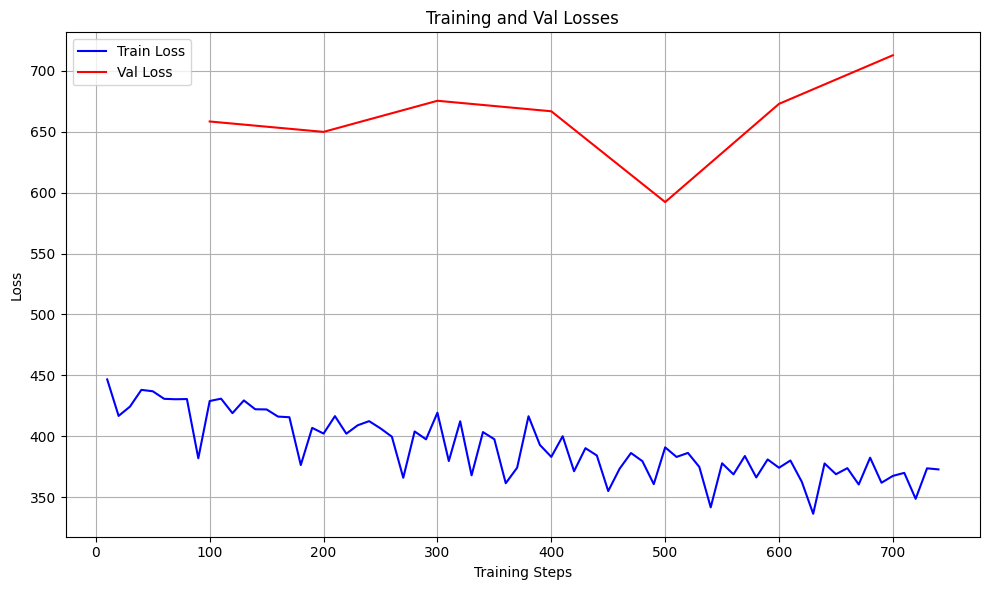

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_losses(trainer):

    logs = trainer.state.log_history

    train_logs = [log for log in logs if 'loss' in log and 'eval_loss' not in log]
    eval_logs = [log for log in logs if 'eval_loss' in log]

    # Extract loss values
    train_steps = [log['step'] for log in train_logs]
    train_losses = [log['loss'] for log in train_logs]

    eval_steps = [log['step'] for log in eval_logs]
    eval_losses = [log['eval_loss'] for log in eval_logs]

    plt.figure(figsize=(10, 6))
    plt.plot(train_steps, train_losses, label='Train Loss', color='blue')
    plt.plot(eval_steps, eval_losses, label='Val Loss', color='red')

    plt.title('Training and Val Losses')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


plot_training_losses(trainer)

In [26]:
# text = """Des vignes, de l'arboriculture, de la production de céréales, de l'élevage avec notamment des vaches laitières et même de l'héliciculture.   Tels sont les projets qui verront prochainement le jour sur une partie du domaine Casabianca en Plaine orientale, plus précisément sur une surface de 260 hectares d'une terre fertile et convoitée. Une conférence de presse, qui réunissait le président du conseil exécutif de Corse, ainsi que ceux de l'office du développement agricole de la Corse (Odarc), de l'agence de développement économique de la Corse (Adec) et de la société d'aménagement foncier et d'établissement rural (Safer), a eu lieu hier en fin d'après-midi à l'hôtel Chez Walter à Lucciana.   L'épilogue, ou presque, de ce long feuilleton, avec pour enjeu principal ce domaine viticole considéré comme l'un des plus grands d'Europe et ses 469 hectares de vignes abandonnées. "Nous sommes aujourd'hui en présence d'un nouveau-né, le fonds de portage du foncier agricole, a indiqué Christian Orsucci, le président de la Safer. C'est historique et c'est la première fois en Corse que nous avons la possibilité de faire du portage de foncier et de mettre en réserve des terres pour y installer des jeunes."Un fonds de portage, donc, qui a pour première mission de mener à bien la répartition de ces terres destinées à de jeunes agriculteurs.   Pour l'instant, sur les 469 hectares, 260 ont été distribués à 20 personnes, hier, par la Safer et l'Odarc. "C'est un dossier qui a été très long à traiter, poursuit Chrisitian Orsucci. Nous avons dû faire face à des problèmes juridiques mais nous avons réussi."Il faut dire que 130 hectares faisaient l'objet d'un litige puisque des agriculteurs qui bénéficiaient déjà d'un bail ont obtenu gain de cause devant les tribunaux. À l'heure actuelle, ce sont donc 330 hectares qui ont été préemptés par la Safer, cette dernière réitérant au passage sa volonté de donner la priorité aux jeunes agriculteurs et, ainsi, freiner d'autres intérêts.  Cinq ans pour lancerson activitéEt les différents présidents - tous - l'ont martelé à plusieurs reprises, il s'agissait d'anéantir toute spéculation. "Jusqu'à il y a quelques mois, on disait encore que c'était des spéculateurs qui allaient récupérer le domaine, a lancé Lionel Mortini, le président de l'Odarc. Aujourd'hui, nous fournissons la preuve que grâce à l'action forte du conseil exécutif, avec un opérateur comme la Safer, nous pouvons réaliser des choses. Même si nous ne sommes pas encore tout à fait propriétaires du domaine, il était important que l'on puisse distribuer ces 260 hectares. Cela va permettre d'installer 25 jeunes agriculteurs puisque certains sont regroupés dans des travaux collectifs."Une satisfaction qui souffre tout de même d'un bémol : le rejet de certaines demandes puisqu'en tout, près de 70 dossiers ont été déposés. "Nous avons tenu notre ligne comme nous l'avions annoncé depuis le début, poursuit Lionel Mortini. La partie du bord de mer a été cédée au Conservatoire du littoral où un agriculteur va s'installer, comme nous le voulions. Nous ne laisserons personne sur le bord de la route. Nous allons voir avec la Safer comment nous pourrons trouver de la terre à ceux qui n'ont pas été retenus aujourd'hui. Nous devions faire des choix mais ils ont été très équilibrés puisque l'attribution des lots s'est faite pratiquement à l'unanimité."Et si les présidents présents se disaient satisfaits, c'est aussi parce que ces attributions comportent des paramètres confortables pour les jeunes agriculteurs. Concrètement, ils ont cinq ans pour lancer leur activité, et c'est à ce terme qu'ils auront la possibilité de faire l'acquisition des terres. "Nous ferons un point dans trois ans, promet Lionel Mortini. Si nous voyons que certaines parcelles sont en friche, elles seront retirées et réattribuées. Le but c'est de relancer la filière agricole. Nous ne sommes pas dans l'incantation, mais dans la réflexion de tout ce que l'on peut faire."Une volonté réaffirmée également par l'acquisition par l'Odarc des bâtiments existants dans le but de créer des aménagements collectifs au service des agriculteurs de la microrégion. "Tout cela est en discussion mais ils pourront développer des circuits courts par exemple, avance son président. Mais aussi des magasins de producteurs ou d'autres choses qui seront réfléchies dans les prochaines semaines." Sur les 330 hectares dont dispose la Safer, 260 ont été alloués hier. Le reste, soit 70 hectares, le sera d'ici à cet été. "C'est une question de semaines, le temps de régler un petit problème qui concerne un locataire qui empiète sur un peu plus que sa parcelle", a conclu Lionel Mortini.   Le retour à la terre, donc, pour ce joyau qui devrait, selon les prévisions de l'Odarc, redevenir l'une des vitrines de l'agriculture insulaire."""

# from nltk.tokenize import word_tokenize

# def split_text_to_max_tokens(text: str, max_tokens: int = 256) -> list:

#     tokens = word_tokenize(text)

#     segments = []
#     for i in range(0, len(tokens), max_tokens):
#         segment_tokens = tokens[i:i + max_tokens]
#         segment_text = " ".join(segment_tokens)
#         segments.append(segment_text)

#     return segments


# resultat = split_text_to_max_tokens(text, max_tokens=510)

# for idx, segment in enumerate(resultat):

#     entities = trained_model.predict_entities(segment, labels)

#     for entity in entities:
#         print(entity["text"], "=>", entity["label"])

In [27]:
text = """Des vignes, de l'arboriculture, de la production de céréales, de l'élevage avec notamment des vaches laitières et même de l'héliciculture.   Tels sont les projets qui verront prochainement le jour sur une partie du domaine Casabianca en Plaine orientale, plus précisément sur une surface de 260 hectares d'une terre fertile et convoitée. Une conférence de presse, qui réunissait le président du conseil exécutif de Corse, ainsi que ceux de l'office du développement agricole de la Corse (Odarc), de l'agence de développement économique de la Corse (Adec) et de la société d'aménagement foncier et d'établissement rural (Safer), a eu lieu hier en fin d'après-midi à l'hôtel Chez Walter à Lucciana.   L'épilogue, ou presque, de ce long feuilleton, avec pour enjeu principal ce domaine viticole considéré comme l'un des plus grands d'Europe et ses 469 hectares de vignes abandonnées. "Nous sommes aujourd'hui en présence d'un nouveau-né, le fonds de portage du foncier agricole, a indiqué Christian Orsucci, le président de la Safer. C'est historique et c'est la première fois en Corse que nous avons la possibilité de faire du portage de foncier et de mettre en réserve des terres pour y installer des jeunes."Un fonds de portage, donc, qui a pour première mission de mener à bien la répartition de ces terres destinées à de jeunes agriculteurs.   Pour l'instant, sur les 469 hectares, 260 ont été distribués à 20 personnes, hier, par la Safer et l'Odarc. "C'est un dossier qui a été très long à traiter, poursuit Chrisitian Orsucci. Nous avons dû faire face à des problèmes juridiques mais nous avons réussi."Il faut dire que 130 hectares faisaient l'objet d'un litige puisque des agriculteurs qui bénéficiaient déjà d'un bail ont obtenu gain de cause devant les tribunaux. À l'heure actuelle, ce sont donc 330 hectares qui ont été préemptés par la Safer, cette dernière réitérant au passage sa volonté de donner la priorité aux jeunes agriculteurs et, ainsi, freiner d'autres intérêts.  Cinq ans pour lancerson activitéEt les différents présidents - tous - l'ont martelé à plusieurs reprises, il s'agissait d'anéantir toute spéculation. "Jusqu'à il y a quelques mois, on disait encore que c'était des spéculateurs qui allaient récupérer le domaine, a lancé Lionel Mortini, le président de l'Odarc. Aujourd'hui, nous fournissons la preuve que grâce à l'action forte du conseil exécutif, avec un opérateur comme la Safer, nous pouvons réaliser des choses. Même si nous ne sommes pas encore tout à fait propriétaires du domaine, il était important que l'on puisse distribuer ces 260 hectares. Cela va permettre d'installer 25 jeunes agriculteurs puisque certains sont regroupés dans des travaux collectifs."Une satisfaction qui souffre tout de même d'un bémol : le rejet de certaines demandes puisqu'en tout, près de 70 dossiers ont été déposés. "Nous avons tenu notre ligne comme nous l'avions annoncé depuis le début, poursuit Lionel Mortini. La partie du bord de mer a été cédée au Conservatoire du littoral où un agriculteur va s'installer, comme nous le voulions. Nous ne laisserons personne sur le bord de la route. Nous allons voir avec la Safer comment nous pourrons trouver de la terre à ceux qui n'ont pas été retenus aujourd'hui. Nous devions faire des choix mais ils ont été très équilibrés puisque l'attribution des lots s'est faite pratiquement à l'unanimité."Et si les présidents présents se disaient satisfaits, c'est aussi parce que ces attributions comportent des paramètres confortables pour les jeunes agriculteurs. Concrètement, ils ont cinq ans pour lancer leur activité, et c'est à ce terme qu'ils auront la possibilité de faire l'acquisition des terres. "Nous ferons un point dans trois ans, promet Lionel Mortini. Si nous voyons que certaines parcelles sont en friche, elles seront retirées et réattribuées. Le but c'est de relancer la filière agricole. Nous ne sommes pas dans l'incantation, mais dans la réflexion de tout ce que l'on peut faire."Une volonté réaffirmée également par l'acquisition par l'Odarc des bâtiments existants dans le but de créer des aménagements collectifs au service des agriculteurs de la microrégion. "Tout cela est en discussion mais ils pourront développer des circuits courts par exemple, avance son président. Mais aussi des magasins de producteurs ou d'autres choses qui seront réfléchies dans les prochaines semaines." Sur les 330 hectares dont dispose la Safer, 260 ont été alloués hier. Le reste, soit 70 hectares, le sera d'ici à cet été. "C'est une question de semaines, le temps de régler un petit problème qui concerne un locataire qui empiète sur un peu plus que sa parcelle", a conclu Lionel Mortini.   Le retour à la terre, donc, pour ce joyau qui devrait, selon les prévisions de l'Odarc, redevenir l'une des vitrines de l'agriculture insulaire."""

nombre_mots = len(text.split())
print("Nombre de mots :", nombre_mots)

Nombre de mots : 765
